In [1]:
%matplotlib widget
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import art3d


In [2]:
# params
nx, nu = 3, 3
T = 20
dt = 0.1
lu = -0.5 # lower bound on u
hu = 0.5  # higher bound on u
gripper = 1. # 1. means the gripper is open
tolerance = 0.0005 # tolerance when gripper has cube under grasp
    
# dynamics
A = np.zeros((nx, nx))
B = np.eye(nx)
Ad = np.eye(nx) + A * dt
Bd = B * dt

In [3]:
# variables
x = cp.Variable((T+1, nx), name='x')
u = cp.Variable((T, nu), name='u')

    # parameters
x0 = cp.Parameter(nx, name="x0")
xd = cp.Parameter(nx, name="xd")
x0.value = np.zeros((nx,))
xd.value = np.zeros((nx,))

In [4]:
# constraints
constraints = []
# upper and lower bounds
constraints += [u <= hu*np.ones((T, nu))]
constraints += [u >= lu*np.ones((T, nu))]
# initial cond
constraints += [x[0] == x0]
# dynamics
for t in range(T):
  constraints += [x[t+1] == Ad @ x[t] + Bd @ u[t]]

In [5]:
# objective
obj = cp.Minimize(sum([cp.norm(xt - xd) for xt in x]))

In [6]:
# put toghether problem
prob = cp.Problem(obj, constraints)

In [7]:
x0.value = np.zeros(3)
xd.value = 0.6*np.ones(3)

prob.solve(solver='MOSEK')


6.754998149518704

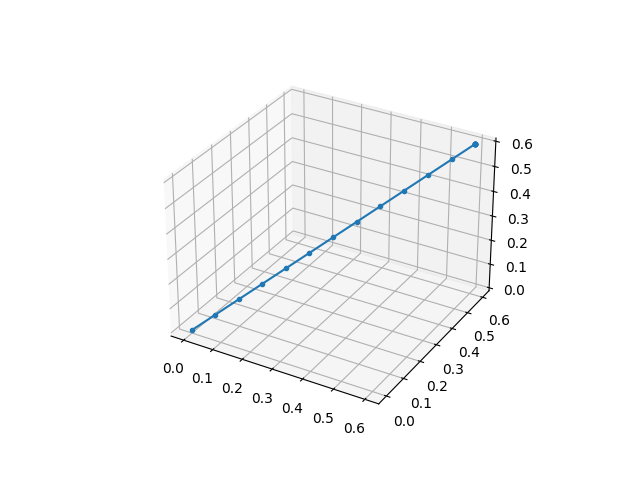

In [8]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectory
ax.plot(x.value[:,0], x.value[:,1], x.value[:,2], '.-')

In [9]:
# obstacle
x_obs = 0.5*np.ones(3)
x_obs_T = np.vstack([x_obs for _ in range(T+1)])
r_obs = 0.1


In [10]:
# variables
x_scp = cp.Variable((T+1, nx), name='x')
u_scp = cp.Variable((T, nu), name='u')
v_scp_dyn = cp.Variable((T+1, nx), name='v_dyn')
v_scp_const = cp.Variable((T+1, 1), name='v_const')

In [11]:
# constraints
constraints_scp = []
# upper and lower bounds
constraints_scp += [u_scp <= hu*np.ones((T, nu))]
constraints_scp += [u_scp >= lu*np.ones((T, nu))]
# initial cond
constraints_scp += [x_scp[0] == x0]
# dynamics
for t in range(T):
  constraints_scp += [x_scp[t+1] == Ad @ x_scp[t] + Bd @ u_scp[t] + np.eye(3) @ v_scp_dyn[t]]

In [12]:
# objective
l = 1000
xd_cost = sum([cp.norm(xt - xd) for xt in x_scp])#cp.norm(x_scp[-1] - xd)
scp_dyn_cost = l * sum([cp.norm(np.eye(nx) @ v_d, 1) for v_d in v_scp_dyn])
scp_const_cost = l * cp.norm(v_scp_const, 1)
obj_scp = cp.Minimize(xd_cost + scp_dyn_cost + scp_const_cost)

In [13]:
i=0
cost_old = float('inf')
cost_new = 0
epsilon = 0.1
constraint_respected = False
while i<20 and ((i==0 or abs(cost_old - cost_new)>epsilon) or not constraint_respected):
  x_bar = x.value if i==0 else x_scp.value
  cost_old = cost_new
  # scp constraints
  distance_norm = np.linalg.norm(x_bar - x_obs_T, 2, axis=1)
  scp_const = []
  for t in range(T+1):
    nt = distance_norm[t]
    scp_const += [(x_bar[t] - x_obs).T/nt @ (x_bar[t]-x_scp[t]) + (r_obs+0.02) - nt <= v_scp_const[t]]
  # reinit prob
  scp_prob = cp.Problem(obj_scp, constraints_scp + scp_const)
  cost_new = scp_prob.solve(solver='MOSEK')
  constraint_respected = min(np.linalg.norm(x_scp.value - x_obs_T, axis=1)) > (r_obs+0.02)
  print(f"Cost = {cost_new}")
  print(f"Collision costraint respected: {constraint_respected}")
  print("")
  i+=1

Cost = 159.76466512037604
Collision costraint respected: False

Cost = 7.3766315683284915
Collision costraint respected: True

Cost = 7.288399073809668
Collision costraint respected: True

Cost = 7.286675509724623
Collision costraint respected: True



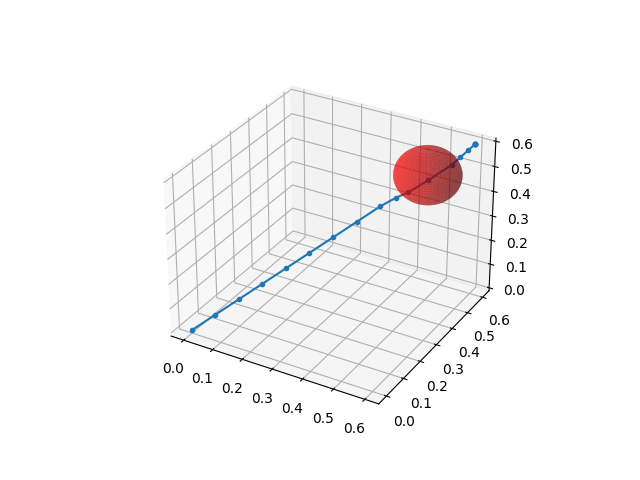

In [14]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectory
ax.plot(x_scp.value[:,0], x_scp.value[:,1], x_scp.value[:,2], '.-')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 50)
x_sphere = x_obs[0] + r_obs * np.outer(np.cos(u), np.sin(v))
y_sphere = x_obs[1] + r_obs * np.outer(np.sin(u), np.sin(v))
z_sphere = x_obs[2] + r_obs * np.outer(np.ones(np.size(u)), np.cos(v))
sphere = ax.plot_surface(x_sphere, y_sphere, z_sphere, color='r', alpha=0.5)